In [55]:
# load packages
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
sns.set_theme()

### Import all files that will be sorted and exported into another .mat file

In [56]:
# Main Directory of processed file from MatLab
#MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles' # set dir
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Files on hand: {d}')
##############################################
FileN = d[-1] # choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Files on hand: ['MAT', 'nl-345215-attnR_20240201_1637_RLS.mat']
Current WD: C:\plimon\LTP_analysis\eegMatFiles\nl-345215-attnR_20240201_1637_RLS.mat
Does File #1 Exist? True


#### Print Keys in original data

In [57]:
mat_data = scipy.io.loadmat(file_path1) # import data file
print((mat_data.keys()))

dict_keys(['__header__', '__version__', '__globals__', 'info', 'signalData', 'noise1', 'noise2'])


#### Index certain keys for analysis and conditions during expt

In [58]:
# find basic data parms 
MainData = mat_data['signalData']
noise1 = mat_data['noise1'] # 6 x 1 
noise2 = mat_data['noise2']
inds = mat_data['info'][0][0]
ExpConds = int(MainData.shape[0])
print(f'Data file contains data for {ExpConds} different conditions')

Data file contains data for 6 different conditions


### Channels to analyze derived from ryans selcted electrodes

In [59]:
elecLeftLateral=[51,52,60,58,59,64,65,68,69]
elecLeftMedial=[72,75,81,70,71,74]
elecRightMedial=[72,75,81,76,83,82]
elecMedial=[72,75,81,70,71,74,76,83,82]
elecRightLateral=[97,92,85,96,91,95,90,94,88]

AnalysisChans = [elecLeftLateral,elecLeftMedial,elecRightMedial,elecMedial,elecRightLateral]

ExportChans = np.sort(np.concatenate(AnalysisChans)) # 39 chans
print(ExportChans)



[51 52 58 59 60 64 65 68 69 70 70 71 71 72 72 72 74 74 75 75 75 76 76 81
 81 81 82 82 83 83 85 88 90 91 92 94 95 96 97]


In [60]:
# save signal data
FreqDataPerCo = {}
for co in range(ExpConds):
    #print(MainData[co][0].shape)
    FreqDataPerCo[co] = MainData[co][0]
# noise data 1 
Noise1DataPerCo = {}
for co in range(ExpConds):
    #print(noise1[co][0].shape)
    Noise1DataPerCo[co] = noise1[co][0]
# noise data 2
Noise2DataPerCo = {}
for co in range(ExpConds):
    #print(noise2[co][0].shape)
    Noise2DataPerCo[co] = noise2[co][0]

In [61]:
co = 0 # pre and post induction ltp
HarmInd = np.ravel(mat_data['info'][0][0] [0][co][0])
BinInd = np.ravel(mat_data['info'][0][0] [1][co][0])
#HarmonLabels = mat_data['info'][0][0][2][co][0]
AvgAct = mat_data['info'][0][0] [3][co] [0] # returns an array with 6 values ...
NumCondInd = mat_data['info'][0][0][4][co][0] # bin index, includes preludes
HemiFieldLabels = mat_data['info'][0][0] [2][co][0] # contains harmonic and hemifield data
hemiFieldnHarmonicInd = mat_data['info'][0][0] [2][co] [0]
#########IN case some nexted arrays need to be extracted or explored
# co = 0
# ind = 2
# inds = mat_data['info'][0][0] [ind][co] [0] # avoid prelude bind which == 0 actually 
# #print(inds)
# for innerlist in inds:
#     for item in innerlist:
#        print(item)

In [62]:
HemiBound = int(int(len(HemiFieldLabels))/2)
print(HemiBound) # index for Fx filter freq

4


#### have to combine real and imaginar before data can be indexed 

In [63]:
NumHarms,NumHarmCount = np.unique(HarmInd, return_counts = True)
print(f'Hamronics:  {NumHarms,NumHarmCount}')
NumBins,NumBinCount = np.unique(BinInd, return_counts = True)
print(f'Bin Indicies:  {NumBins,NumBinCount}')

Bins = int(len(NumBins)-1)

Hamronics:  (array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([7, 7, 7, 7, 7, 7, 7, 7], dtype=int64))
Bin Indicies:  (array([0, 1, 2, 3, 4, 5, 6], dtype=uint8), array([8, 8, 8, 8, 8, 8, 8], dtype=int64))


In [64]:
SortDataIn =  FreqDataPerCo[0] # 112 x 128 x 78
[NumRows, NumChans, NumTrials] = SortDataIn.shape # get dims of data to use later ..
print(SortDataIn.shape)
real_imag_bound = int((NumRows/2))
print(f'Data real-imag bound is at row: #{real_imag_bound}')
chanInd = np.arange(1,NumChans,1)
prepost_bound = int(NumTrials/2)

(112, 128, 78)
Data real-imag bound is at row: #56


#### Combine Real and Imaginary Components of data

In [65]:
# segment data into real and imaginary data side by side
dIn = FreqDataPerCo[co].reshape(real_imag_bound,2,NumChans,NumTrials) # 56 x 2 x 128 x 78
n1 = Noise1DataPerCo[co].reshape(real_imag_bound,2,NumChans,NumTrials)
n2 = Noise2DataPerCo[co].reshape(real_imag_bound,2,NumChans,NumTrials)
# remove 0s -> nans
dIn[dIn == 0] = np.nan
n1[n1 == 0] = np.nan
n2[n2 == 0] = np.nan
# combine real and imaginary compnents for signal data, noise 1 and noise 2 
DataOut = np.zeros((real_imag_bound,NumChans,NumTrials))
n1Out = np.zeros_like(DataOut)
n2Out = np.zeros_like(DataOut)

for val in range(real_imag_bound):
    DataOut[val,:,:] = np.hypot(dIn[val,0,:,:],dIn[val,1,:,:]) # (56,128, 78)
    n1Out[val,:,:] = np.hypot(n1[val,0,:,:],n1[val,1,:,:]) # (56, 128, 78)
    n2Out[val,:,:] = np.hypot(n2[val,0,:,:],n2[val,1,:,:]) # (56, 128, 78)

print(DataOut.shape)

(56, 128, 78)


#### Get data per bin and store in dict, remove prelude bins

In [66]:
dataPerBin = {}

for i in range(len(NumBins)):
    if i > 0:
        bin_arr = np.zeros_like((BinInd))
        bin_arr[BinInd == i] = 1
        dataPerBin[i-1] = DataOut[bin_arr == 1,:,:]

#### F1 and F2 data are stacked on top of each other so here we split them :)

In [67]:
xF1Bins = {} # data is : 2f1 4f1 6f1 8f1
xF2Bins = {} # data is  2f2 4f2 6f2 8f2

for i in range(6):
    data2split = dataPerBin[i] # 8 x 128 x 78

    xF1Bins[i] = np.array(data2split[:HemiBound,:,:])# harmonics x channels x trials  = 4 x 128 x 78
    xF2Bins[i] = np.array(data2split[HemiBound:,:,:]) # harmonics x channels x trials 

Channrl activity per trial: harmonic, bin and hemifield


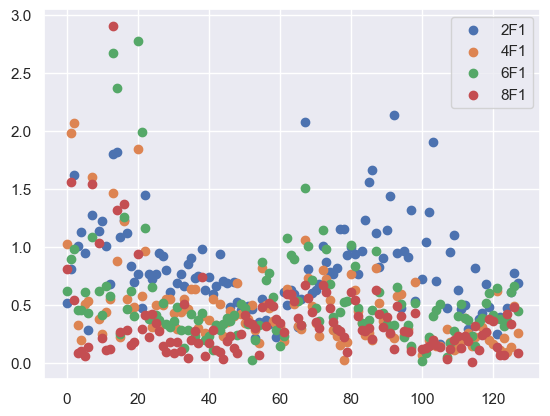

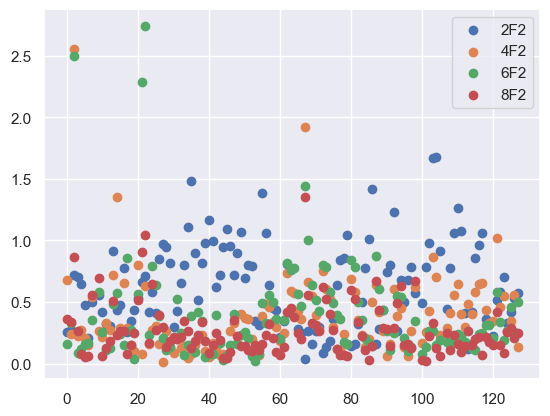

In [68]:
pickBin = 4
print(f'Channrl activity per trial: harmonic, bin and hemifield')
ch_list = np.arange(0,NumChans,1)
for i in range(4):
    plt.scatter(ch_list,xF1Bins[pickBin][i,:,70], label = f'{(i+1)*2}F1') # plot per channel actiivity 
    plt.legend()
plt.show()

for i in range(4):
    plt.scatter(ch_list,xF2Bins[pickBin][i,:,70], label = f'{(i+1)*2}F2') # plot per channel actiivity 
    plt.legend()
plt.show()

### seperate data into pre and post 

In [69]:
prepost_bound= int(NumTrials/2) # reshape will occure at this ind 

xF1_pre_post = {} # F1 pre post data
xF2_pre_post = {} # F2 pre post data

for i in range(6):
    xF1_pre_post[i] = np.reshape(xF1Bins[i], newshape = (4,NumChans,prepost_bound,2))
    xF2_pre_post[i] = np.reshape(xF2Bins[i], newshape = (4,NumChans,prepost_bound,2)) # 4 x 128 x pre / post trials  x 2# 

#### visualize data not for analysis - data is not comperable but more to make sure there is variance between trials, hemifields and harmonics

channel activity per trial: harmonic, bin and hemifield


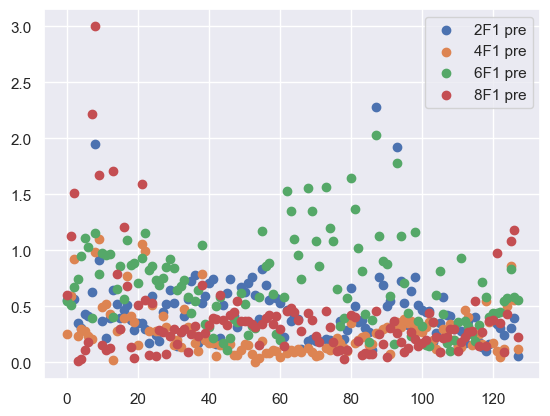

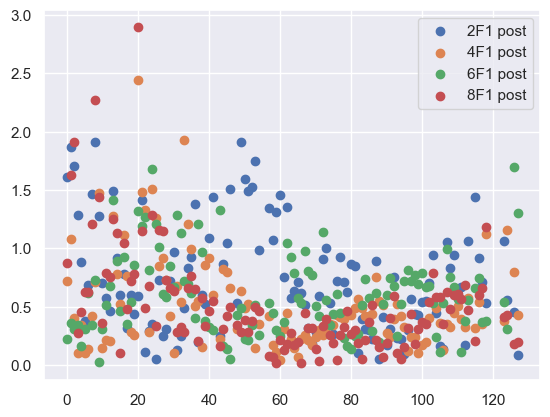

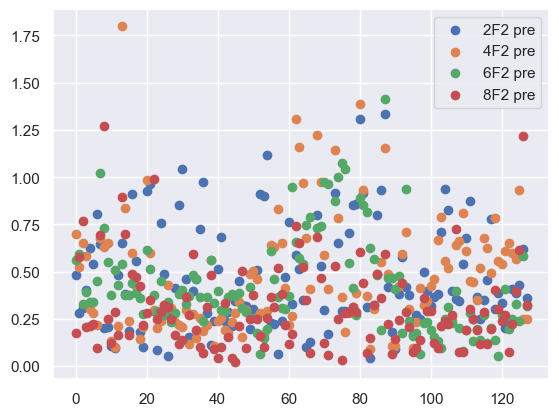

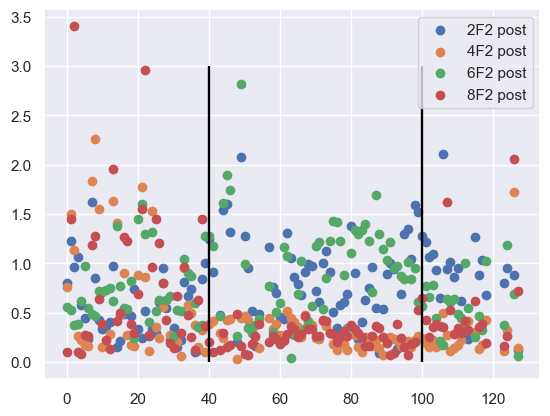

In [70]:
pickBin = 2
print(f'channel activity per trial: harmonic, bin and hemifield')
ch_list = np.arange(0,NumChans,1)

for i in range(4):
    plt.scatter(ch_list,xF1_pre_post[pickBin][i,:,19,0], label = f'{(i+1)*2}F1 pre') # plot per channel actiivity 
    plt.legend()
plt.show()
for i in range(4):
    plt.scatter(ch_list,xF1_pre_post[pickBin][i,:,19,1], label = f'{(i+1)*2}F1 post') # plot per channel actiivity 
    plt.legend()
plt.show()

for i in range(4):
    plt.scatter(ch_list,xF2_pre_post[pickBin][i,:,19,0], label = f'{(i+1)*2}F2 pre') # plot per channel actiivity 
    plt.legend()
plt.show()
for i in range(4):
    plt.scatter(ch_list,xF2_pre_post[pickBin][i,:,19,1], label = f'{(i+1)*2}F2 post') # plot per channel actiivity 
    plt.vlines(40, ymin = 0 , ymax = 3, color = 'black')
    plt.vlines(100, ymin = 0, ymax = 3, color = 'black')
    plt.legend()
plt.show()

#### concate data across bins to create avg activity per channel per bin

In [71]:
xF1_CleanAvgs = {}
xF2_CleanAvgs = {}

for prepost in range(2):
    xF1_CleanAvgs[prepost] = {} # make a new dict key for pre and then post 
    xF2_CleanAvgs[prepost] = {}
    for bin in range(6):
        #enter data dict
        xF1_dIn = xF1_pre_post[bin] # 4  x 128 x ntrials x pre / post
        xF2_dIn = xF2_pre_post[bin]
        # avg harmonic activity per channel
        xF1_CleanAvgs[prepost][bin] = np.nanmean(xF1_dIn[:,:,:,prepost],axis = -1) # average data per trial to get 1 val per channel
        xF2_CleanAvgs[prepost][bin] = np.nanmean(xF2_dIn[:,:,:,prepost],axis = -1) # average data per trial to get 1 val per channel

#### Sanity check plot

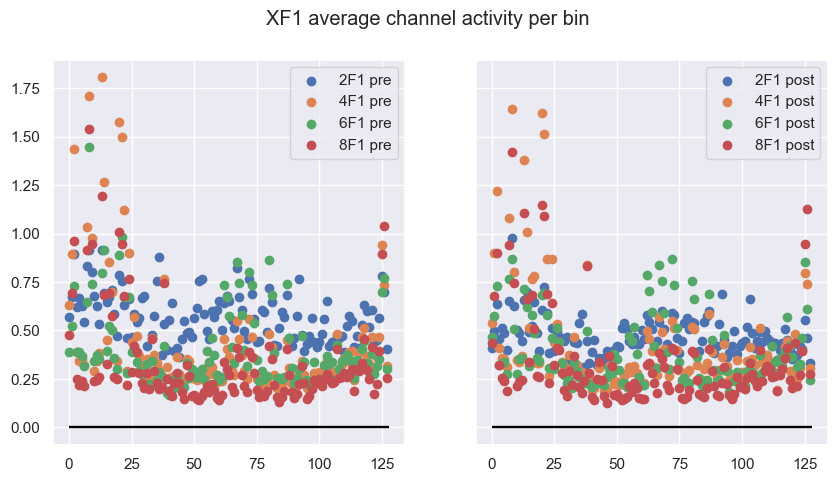

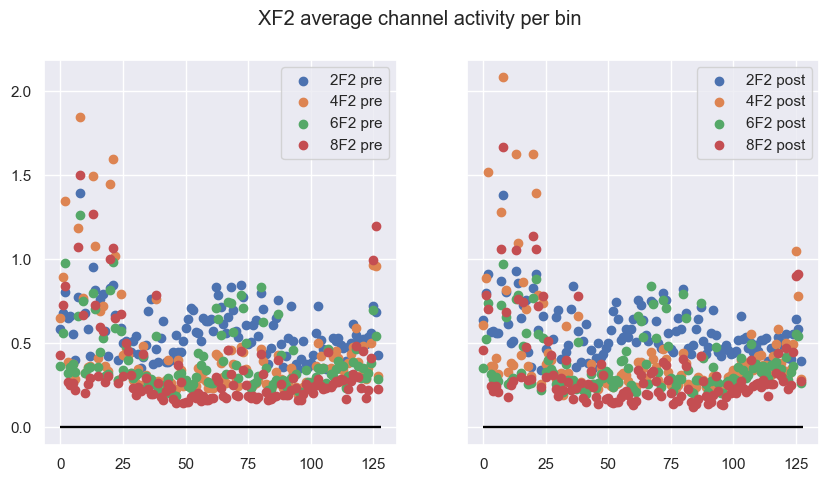

In [72]:
pepo = ['pre', 'post']

binInd = 4
fig, axs = plt.subplots(1,2,figsize = (10,5),sharey = True)
for prepost in range(2):
    dIn = xF1_CleanAvgs[prepost]
    for hi in range(4):
        axs[prepost].scatter(ch_list,dIn[binInd][hi,:], label = f'{(hi+1)*2}F1 {pepo[prepost]}')
        axs[prepost].hlines(0,xmin = 0,xmax = 128, color = 'black')
    plt.suptitle('XF1 average channel activity per bin')
    axs[prepost].legend()


fig, axs = plt.subplots(1,2,figsize = (10,5),sharey = True)
for prepost in range(2):
    dIn = xF2_CleanAvgs[prepost]
    for hi in range(4):
        axs[prepost].scatter(ch_list,dIn[binInd][hi,:], label = f'{(hi+1)*2}F2 {pepo[prepost]}')
        axs[prepost].hlines(0,xmin = 0,xmax = 128, color = 'black')
    plt.suptitle('XF2 average channel activity per bin')
    axs[prepost].legend()


#### Combine data across harmonics 

In [73]:
XF1_Data = {}
XF2_Data = {}

for prepost in range(2):
    XF1_Data[prepost] = {}
    XF2_Data[prepost] = {}

    temp_XF1 = np.concatenate([xF1_CleanAvgs[prepost][x] for x in xF1_CleanAvgs[prepost]])
    temp_XF2 = np.concatenate([xF2_CleanAvgs[prepost][x] for x in xF2_CleanAvgs[prepost]])

    XF1_Data[prepost] = np.reshape(temp_XF1, newshape = (4,6,NumChans))
    XF2_Data[prepost] = np.reshape(temp_XF2, newshape =(4,6,NumChans))


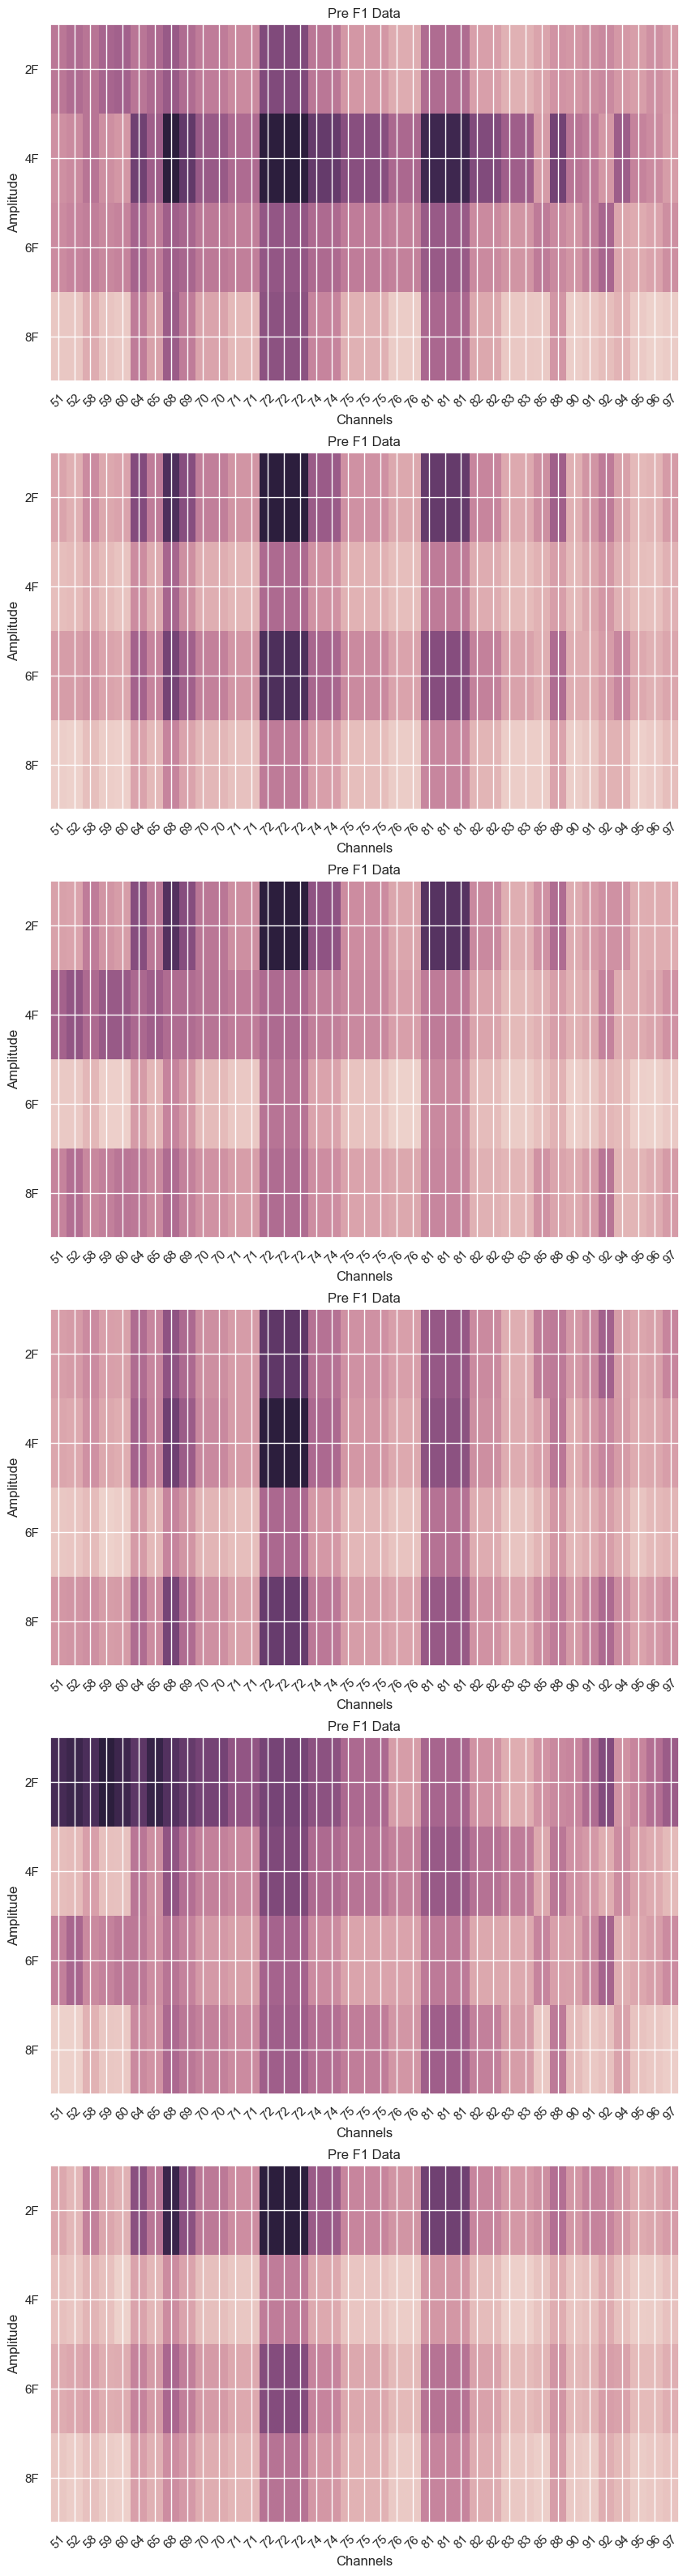

In [74]:
h_label = ['2F','4F','6F','8F']

fig,axs = plt.subplots(6,1, figsize = (10,40))
for i in range(6):
    dIn = axs[i].imshow(XF1_Data[0][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
    axs[i].set_xticks(np.arange(len(ExportChans)))
    axs[i].set_xticklabels(ExportChans,rotation=45)
    axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
    axs[i].set_yticklabels(h_label) 
    axs[i].set_title('Pre F1 Data')
    axs[i].set_xlabel('Channels')
    axs[i].set_ylabel('Amplitude')
#plt.show()

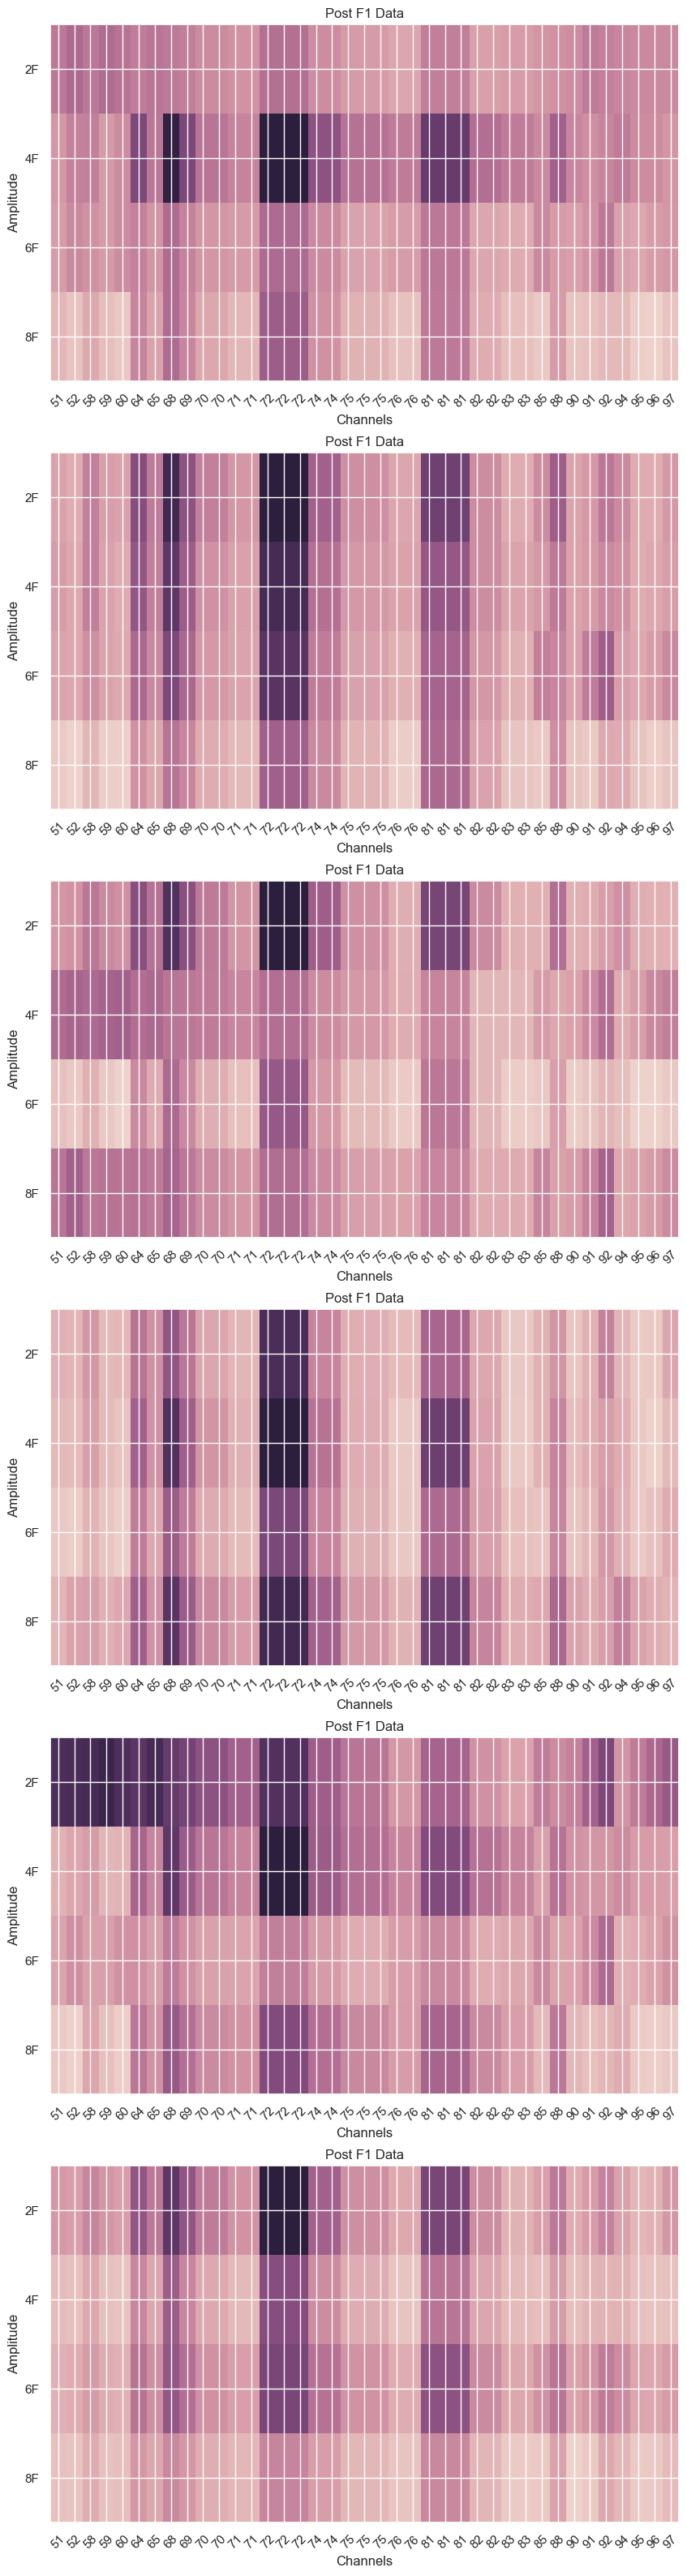

In [75]:
fig,axs = plt.subplots(6,1, figsize = (10,40))
for i in range(6):
    dIn = axs[i].imshow(XF1_Data[1][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
    axs[i].set_xticks(np.arange(len(ExportChans)))
    axs[i].set_xticklabels(ExportChans,rotation=45)
    axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
    axs[i].set_yticklabels(h_label) 
    axs[i].set_title('Post F1 Data')
    axs[i].set_xlabel('Channels')
    axs[i].set_ylabel('Amplitude')

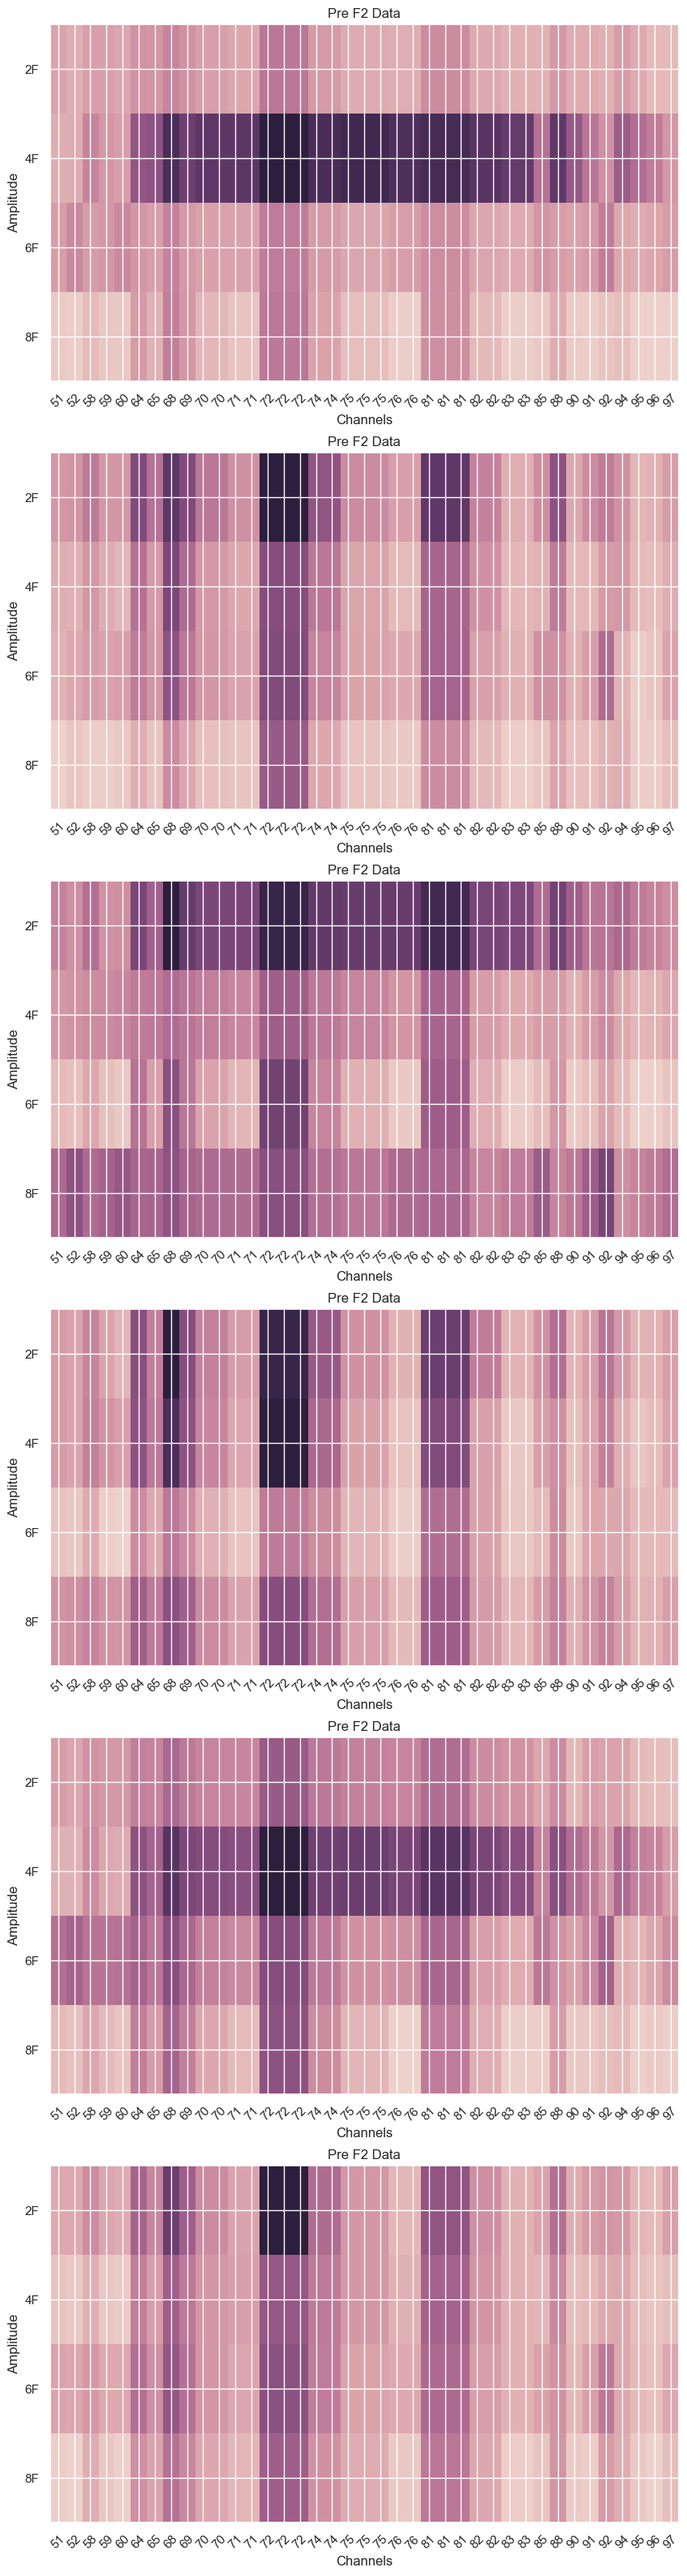

In [76]:
fig,axs = plt.subplots(6,1, figsize = (10,40))
for i in range(6):
    dIn = axs[i].imshow(XF2_Data[0][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
    axs[i].set_xticks(np.arange(len(ExportChans)))
    axs[i].set_xticklabels(ExportChans,rotation=45)
    axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
    axs[i].set_yticklabels(h_label) 
    axs[i].set_title('Pre F2 Data')
    axs[i].set_xlabel('Channels')
    axs[i].set_ylabel('Amplitude')

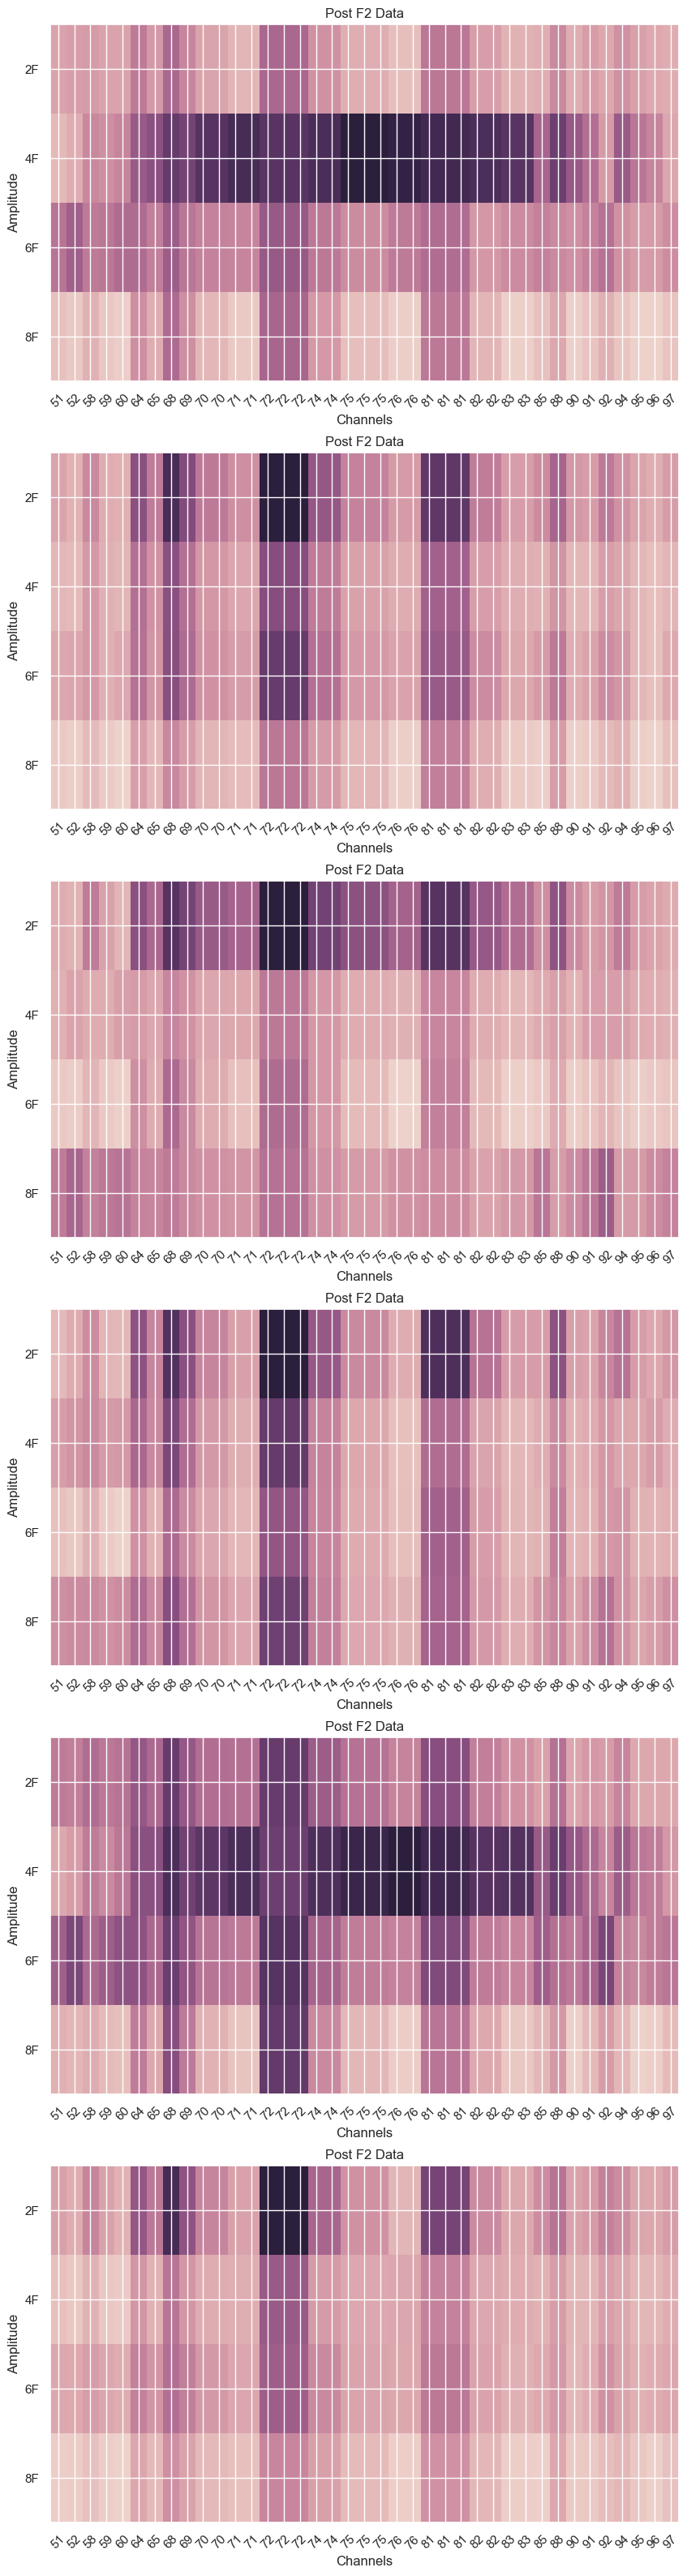

In [77]:
fig,axs = plt.subplots(6,1, figsize = (10,40))
for i in range(6):
    dIn = axs[i].imshow(XF2_Data[1][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
    axs[i].set_xticks(np.arange(len(ExportChans)))
    axs[i].set_xticklabels(ExportChans,rotation=45)
    axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
    axs[i].set_yticklabels(h_label) 
    axs[i].set_title('Post F2 Data')
    axs[i].set_xlabel('Channels')
    axs[i].set_ylabel('Amplitude')

(128,)
(128,)
(128,)
(128,)
(128,)
(128,)


Text(0.5, 1.0, 'activity per channel across all bins')

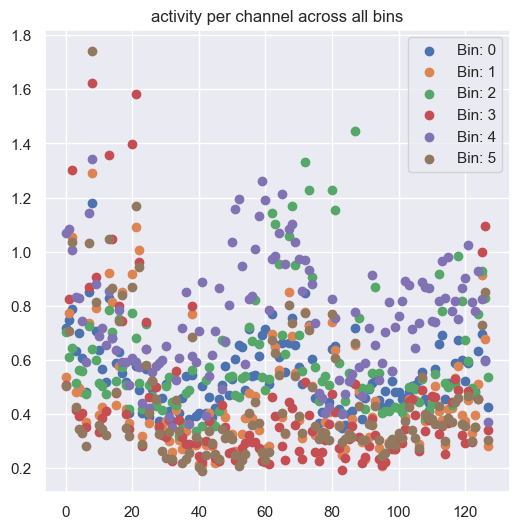

In [78]:
fig,axs = plt.subplots(1, figsize = (6,6))
p = XF1_Data[0]

for i in range(6):
    harmtwo  = p[0,i,:]
    print(harmtwo.shape)
    #ht = np.nanmean(harmtwo,axis = 0)
    #print(ht.shape) # 128 
    axs.scatter(ch_list,harmtwo, label = f'Bin: {i}')
    axs.legend()
plt.title(f'activity per channel across all bins')

In [79]:
import mne
#from mne.channels.montage import get_builtin_montages
#from mne.datasets import fetch_fsaverage
#from mne.viz import set_3d_title, set_3d_view
from mne import create_info
from mne.io import RawArray
from mne.viz import plot_topomap

#### Select EEG Cap to be used

In [ ]:
# montage_type = mne.channels.make_standard_montage("GSN-HydroCel-128")
# print(montage_type)

#### import coordinates from EEG system - which sets montage

In [83]:
eegMontageDir = 'C:\\plimon\\LTP_analysis\\eegSensorLocs\\9_18AverageNet128_v1.sfp'#AdultAverageNet128_v1.sfp'

# Check if the file exists
if os.path.exists(eegMontageDir):
    # Load the electrode locations file
    montageIn = mne.channels.read_custom_montage(eegMontageDir) # import file
    print("Electrode locations loaded successfully.")
else:
    print("The specified file does not exist.")
print(montageIn)
#### Get channel names to use
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)

Electrode locations loaded successfully.
<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 129 channels>


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,132 points
Good channels,129 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1.00 Hz
Highpass,0.00 Hz
Lowpass,0.50 Hz


### Maybe dont have the correct egi corrdinates(?) - have to  add an additional row to make up for last channel missingmaybe ref (should keep as nan maybe )

In [85]:
topodata = p[0,:,:].T
print(topodata.shape)
emptyChData = np.ones((1,6))

data = np.array(np.concatenate((topodata,emptyChData)))

data = data[:,0]
print(data.shape)

(128, 6)
(129,)


In [ ]:
# raw = RawArray(data,info)
# raw.set_montage(montage)

# plot_topomap(raw, pos = )

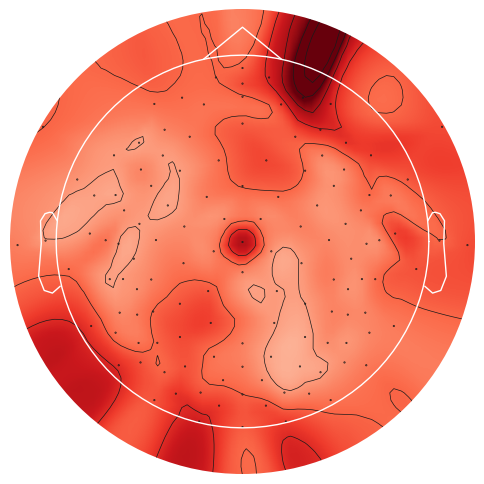

In [87]:
# create array with 4 points for our 4 channels
# in the same order as provided in ch_names
fig, axs = plt.subplots(figsize = (6,7))
info = create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types='eeg')
# channel names I provided are part of a standard montage
info.set_montage(montageIn) # import file)
plot_topomap(data, info, axes = axs)

plt.show()

### Good confined example of what data formate is supposed to look like for mne plotting success

In [ ]:
# from mne import create_info
# from mne.viz import plot_topomap
# import numpy as np

# # create array with 4 points for our 4 channels
# # in the same order as provided in ch_names
# data = np.random.randn(4)  
# info = create_info(ch_names=['CPz', 'Oz', 'POz', 'Fz'], sfreq=1000, ch_types='eeg')
# # channel names I provided are part of a standard montage
# info.set_montage('standard_1020')

# plot_topomap(data, info)

#### Find EEG Sys and EEG Sensor Locations

In [ ]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
montageIn.plot(kind='3d', axes=ax)
ax.set_title('Sensor Locations')
plt.show()

In [ ]:
# Plot the sensors on a 2D head model
fig, ax = plt.subplots()
montageIn.plot(kind='topomap', show_names=True, axes=ax)
ax.set_title('Sensor Locations (2D)')
plt.show()